In [10]:
import pandas as pd

# get embedding vectors - each row is a job posting, each column is a feature
embeddings = pd.read_csv('text_embeddings.csv', index_col=0)

all_postings = pd.read_csv('processed_description.csv', index_col=0)

text = all_postings['processed_description']
salary_bins = all_postings['salary_bin']
salary_ranges = all_postings['salary_range']





## Split train, validation, and test set: 


In [11]:
from sklearn.model_selection import train_test_split



X_train, X_test, y_train, y_test = train_test_split(embeddings, salary_bins, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

## Logistic Regression

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_recall_curve, auc

model = LogisticRegression(max_iter=1000, C = 1)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)



print('Accuracy:', accuracy_score(y_test, y_pred))
print('F1:', f1_score(y_test, y_pred, average='weighted'))
print('AUROC:', roc_auc_score(y_test, y_pred_proba, multi_class='ovr'))





Accuracy: 0.5838951310861423
F1: 0.5801127152649272
AUROC: 0.8205238544057819


## Random Forest Classifier

In [25]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, max_depth=20)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

print('Accuracy:', accuracy_score(y_test, y_pred))
print('F1:', f1_score(y_test, y_pred, average='weighted'))
print('ROC AUC:', roc_auc_score(y_test, y_pred_proba, multi_class='ovr'))



Accuracy: 0.6209737827715356
F1: 0.6108050157548137
ROC AUC: 0.8449678741548263


## XGBoost

In [26]:
import xgboost as xgb

xgb = xgb.XGBClassifier(objective='multi:softmax', num_class=5, max_depth=20, n_estimators=100)
xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)
y_pred_proba = xgb.predict_proba(X_test)

print('Accuracy:', accuracy_score(y_test, y_pred))
print('F1:', f1_score(y_test, y_pred, average='weighted'))
print('ROC AUC:', roc_auc_score(y_test, y_pred_proba, multi_class='ovr'))



Accuracy: 0.6262172284644195
F1: 0.6227912112059231
ROC AUC: 0.8498956393466891


## Feed Forward Network

In [28]:
#  feedforward
from sklearn.neural_network import MLPClassifier

model = MLPClassifier(hidden_layer_sizes=(100,50) , max_iter=1000, learning_rate='adaptive', )
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

print('Accuracy:', accuracy_score(y_test, y_pred))
print('F1:', f1_score(y_test, y_pred, average='weighted'))
print('ROC AUC:', roc_auc_score(y_test, y_pred_proba, multi_class='ovr'))



Accuracy: 0.601123595505618
F1: 0.6018189006020477
ROC AUC: 0.8058940526022109


## Deep Neural Network

In [80]:
import torch
import torch.nn as nn
import torch.optim as optim

class NN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, hidden_layers=200):
        super(NN, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_dim, hidden_dim))
        self.layers.append(nn.ReLU())
        for i in range(hidden_layers):
            self.layers.append(nn.Linear(hidden_dim, hidden_dim))
            self.layers.append((nn.ReLU()))
        self.layers.append(nn.Linear(hidden_dim, output_dim))
        self.layers.append(nn.Softmax())
        

    
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    


In [81]:
# create train and test loaders
from torch.utils.data import TensorDataset, DataLoader

X_train_tensor = torch.tensor(X_train.values).float()
y_train_tensor = torch.tensor(y_train.values).float()
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

X_test_tensor = torch.tensor(X_test.values).float()
y_test_tensor = torch.tensor(y_test.values).float()
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True)




In [124]:
device = 'mps'
from sklearn.metrics import roc_auc_score, auc, precision_recall_curve
from torch.nn import functional as F
def train(epoch, model, optimizer, verbose=False):
    model.train()
    epoch_loss = 0
    losses = []
    for batch_idx, (data, target) in enumerate(train_loader):
        # send data to device, where the "device" is either a GPU if it exists or a CPU
        data, target = data.to(device), target.to(device)
        
       
        optimizer.zero_grad()
        # forward pass through the model
        output = model(data)
        # forward pass through the cross-entropy loss function
        loss = F.cross_entropy(output, target)
        # backward pass through the cross-entropy loss function and the model
        loss.backward()
        
        optimizer.step()
        if batch_idx % 50 == 0:
            losses.append(loss.detach())
            if verbose :
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.item()))
    return losses

def test(model, verbose=False):
    model.eval()
    accuracy_list = []
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            # send data to device, where the "device" is either a GPU if it exists or a CPU
            data, target = data.to(device), target.to(device)

            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item() # sum up batch loss                                                               
            pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability      
                                                                       
            correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()

        test_loss /= len(test_loader.dataset)
        accuracy = 100. * correct / len(test_loader.dataset)
        accuracy_list.append(accuracy) 
        if verbose :
            print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
                test_loss, correct, len(test_loader.dataset),
                accuracy))
    return test_loss
        
    
  



In [93]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

hidden_dim = 100
hidden_layers = 25
input_dim = embeddings.shape[1]
output_dim = 4
model = NN(input_dim, hidden_dim, output_dim, hidden_layers)

optimizer = optim.Adam(model.parameters(), lr=0.0001)

model.to(device)    

for epoch in range(0, 10):
    train(epoch, model, optimizer, verbose=True)
    test(model, verbose=True)



# y_pred = model(X_test_tensor.to(device))
# y_pred = y_pred.argmax(dim=1).cpu().detach().numpy()
# y_test = y_test_tensor.numpy()

# print('Accuracy:', accuracy_score(y_test, y_pred))
# print('F1:', f1_score(y_test, y_pred, average='weighted'))
# print('ROC AUC:', roc_auc_score(y_test, y_pred, multi_class='ovr'))



Train Epoch: 0 [0/8544 (0%)]	Loss: 1.383192
Train Epoch: 0 [400/8544 (5%)]	Loss: 1.369093
Train Epoch: 0 [800/8544 (9%)]	Loss: 1.362616
Train Epoch: 0 [1200/8544 (14%)]	Loss: 1.365144
Train Epoch: 0 [1600/8544 (19%)]	Loss: 1.394041
Train Epoch: 0 [2000/8544 (23%)]	Loss: 1.386245
Train Epoch: 0 [2400/8544 (28%)]	Loss: 1.364973
Train Epoch: 0 [2800/8544 (33%)]	Loss: 1.344723
Train Epoch: 0 [3200/8544 (37%)]	Loss: 1.447926
Train Epoch: 0 [3600/8544 (42%)]	Loss: 1.202145
Train Epoch: 0 [4000/8544 (47%)]	Loss: 1.537641
Train Epoch: 0 [4400/8544 (51%)]	Loss: 1.462501
Train Epoch: 0 [4800/8544 (56%)]	Loss: 1.347900
Train Epoch: 0 [5200/8544 (61%)]	Loss: 1.439529
Train Epoch: 0 [5600/8544 (66%)]	Loss: 1.431099
Train Epoch: 0 [6000/8544 (70%)]	Loss: 1.374487
Train Epoch: 0 [6400/8544 (75%)]	Loss: 1.215461
Train Epoch: 0 [6800/8544 (80%)]	Loss: 1.513960
Train Epoch: 0 [7200/8544 (84%)]	Loss: 1.467368
Train Epoch: 0 [7600/8544 (89%)]	Loss: 1.243886
Train Epoch: 0 [8000/8544 (94%)]	Loss: 1.368021


### RNN

In [129]:


# class RNN(nn.Module):
#     def __init__(self, embedding_dim, hidden_dim, output_dim):
#         super(RNN, self).__init__()
#         self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
#         self.fc = nn.Linear(hidden_dim, output_dim)

#         self.softmax = nn.Softmax()

#     def forward(self, x):
#         x, _ = self.lstm(x)
#         x = self.fc(x)
#         x = self.softmax(x)
#         return x
    
    
    # Create RNN Model
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(RNNModel, self).__init__()
        
        # Number of hidden dimensions
        self.hidden_dim = hidden_dim
        
        # Number of hidden layers
        self.layer_dim = layer_dim
        
        # RNN
        self.rnn = nn.RNN(input_dim, hidden_dim, layer_dim, batch_first=True, nonlinearity='relu')
        
        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    
    def forward(self, x):
        
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(device)

        
        # One time step
        out, hn = self.rnn(x, h0)
        out = self.fc(out[:, -1, :]) 
   
        
        return out

In [131]:
embedding_dim = embeddings.shape[1]
hidden_dim = 10
output_dim = 4
layer_dim = 1
model = RNNModel(embedding_dim, hidden_dim,layer_dim, output_dim)

optimizer = optim.Adam(model.parameters(), lr=0.001)

model.to(device)

for epoch in range(0, 10):
    train(epoch, model, optimizer, verbose=True)
    test(model, verbose=True)
    

RuntimeError: For unbatched 2-D input, hx should also be 2-D but got 3-D tensor

## Self-Attention LSTM

In [112]:

class SelfAttention(nn.Module):
    def __init__(self, hidden_dim):
        super(SelfAttention, self).__init__()
        self.hidden_dim = hidden_dim
        self.projection = nn.Sequential(
            nn.Linear(hidden_dim, 64),
            nn.ReLU(True),
            nn.Linear(64, 1)
        )

    def forward(self, encoder_outputs):
        # encoder_outputs shape: (batch_size, sequence_length, hidden_dim)
        energy = self.projection(encoder_outputs)  # (batch_size, sequence_length, 1)
        weights = F.softmax(energy.squeeze(-1), dim=1)  # (batch_size, sequence_length)
        outputs = (encoder_outputs * weights.unsqueeze(-1)).sum(dim=1)  # (batch_size, hidden_dim)
        return outputs, weights

class LSTMWithAttention(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(LSTMWithAttention, self).__init__()
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.attention = SelfAttention(hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        attn_out, attn_weights = self.attention(lstm_out)
        out = self.fc(attn_out)
        return out, attn_weights


In [113]:
input_dim= embeddings.shape[1]
hidden_dim = 50
output_dim = 4
model = LSTMWithAttention(input_dim, hidden_dim, output_dim)

optimizer = optim.Adam(model.parameters(), lr=0.0001)

model.to(device)

for epoch in range(0, 10):
    train(epoch, model, optimizer, verbose=True)
    test(model, verbose=True)
    

IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

## Dimensionality Reduction with UMAP

<Axes: >

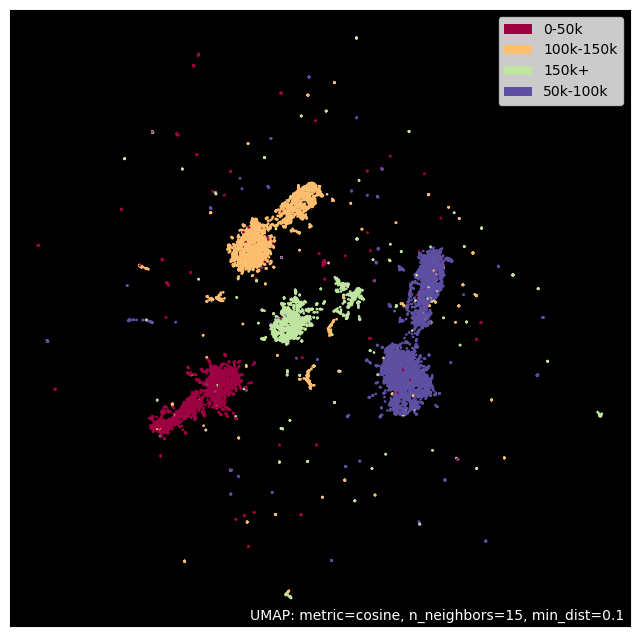

In [29]:
# UMAP for dimensionality reduction
import umap
import umap.plot
import matplotlib.pyplot as plt



reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, metric='cosine')
embedding = reducer.fit_transform(embeddings, salary_bins)

umap.plot.points(reducer, labels=salary_ranges, theme='inferno')









In [45]:
# Logistic regression for classification with the reduced dimensionality
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(embedding, salary_bins, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

logreg = LogisticRegression(max_iter=1000, C=0.01)
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)
y_pred_proba = logreg.predict_proba(X_test)

print('Accuracy:', accuracy_score(y_test, y_pred))
print('F1:', f1_score(y_test, y_pred, average='weighted'))
print('ROC AUC:', roc_auc_score(y_test, y_pred_proba, multi_class='ovr'))


Accuracy: 0.8333333333333334
F1: 0.821221785126714
ROC AUC: 0.927171888564753


### MPNetForSequenceClassification

In [38]:
from torch.utils.data import Dataset, DataLoader

class EmbeddingDataset(Dataset):
    def __init__(self, embeddings, labels):
        self.embeddings = embeddings
        self.labels = labels

    def __len__(self):
        return len(self.embeddings)

    def __getitem__(self, idx):
        return self.embeddings[idx], self.labels[idx]

In [37]:
embedding_tensor = torch.tensor(embedding).float()
label_tensor = torch.tensor(salary_bins).long()

dataset = EmbeddingDataset(embedding_tensor, label_tensor)

batch_size = 32
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)









/Users/krysten/anaconda3/lib/python3.11/site-packages/transformers/utils/generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
